# Intelligent Agents: Vacuum-cleaner World


## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square is cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To starte, the agent is placed on a random square.

__Actuators:__ The agent can `clean` the current square or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
from numpy import random
import numpy as np
from copy import copy, deepcopy

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
actions = ["north", "east", "west", "south", "suck"]


def simple_randomized_agent(bumpers, dirty):
    return random.choice(actions)

In [2]:
simple_randomized_agent({"north" : True, "east" : False, "south" : False, "west" : True}, True)

'north'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

This simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns the performance measure which is here the number of cleaned squares (since all squares are constantly dirty, it is the number of `suck` actions by the agent). 

In [3]:
from numpy import random
from pprint import pprint
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned

#simple_environment(simple_randomized_agent, max_steps = 10000,  verbose = False)

Do one simulation run with 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: south
step 1 - action: east
step 2 - action: south
step 3 - action: north
step 4 - action: east
step 5 - action: west
step 6 - action: south
step 7 - action: east
step 8 - action: west
step 9 - action: north
step 10 - action: north
step 11 - action: north
step 12 - action: north
step 13 - action: north
step 14 - action: east
step 15 - action: west
step 16 - action: west
step 17 - action: west
step 18 - action: north
step 19 - action: north


0

# Tasks

_Submission Instructions:_ Use this notebook to prepare your submission. Complete this section with your code and results. You can add additional Markdown blocks for your description, comments in the code and use mathplotlib to produce charts. 

_Note:_ Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design. 


## Task 1: Implement a simulation environment [2 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty.
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment needs to work with the simple randomized agent program from above and then it can be used for your agent implementation in the tasks below.

In [5]:
def environment(agent, max_steps, verbose = True, length = 5, width = 5, room = '', dirty_count = 0):
    #local variables used to keep track of the room and the agent
    num_cleaned = 0
    possiblyDirty = [False, False, False, False, True]
    
    #establish the room    
    x_location = random.randint(length)
    y_location = random.randint(width)
    if room == '':
        room = [[]] * 5
        for x in range(length):
            room[x] = [False] * width
            for y in range(width):
                room[x][y] = random.choice(possiblyDirty)
                if(room[x][y]):
                    dirty_count = dirty_count + 1

        
            
    if (verbose):
        print('The room is set up')
        print(f"There is {dirty_count} dirty sqaures")
        print(f"The room size is {length}X{width}")
        print(f"The robot is {x_location},{y_location}")
        print(f"Starting actions")
        print(f"_______________________________________")
        
    #start making actions
    for i in range(max_steps):
        #set up the agents percepts
        dirty = room[x_location][y_location]
        bumpers = {"north" : y_location == 0, 
                   "south" : y_location == length - 1, 
                   "west" : x_location == 0, 
                   "east" : x_location == width - 1}
        if(verbose):
            print(f"the agent percives {dirty}, with bumpers: {bumpers}")
            print(f"\t and is in {x_location},{y_location}")
        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck" and dirty): 
            num_cleaned = num_cleaned + 1
            dirty_count = dirty_count - 1
            room[x_location][y_location] = False
        elif (action == "east"):
            x_location  = min(width - 1, x_location + 1)
        elif (action == "west"):
            x_location  = max(0, x_location - 1)
        elif (action == "south"):
            y_location  = min(length -1, y_location + 1)
        elif (action == "north"):
            y_location  = max(0, y_location - 1)
        if(verbose):
            print(f"{x_location},{y_location},{dirty}")
            print(f"*****")
            print(f"Step {i} dirty tiles {dirty_count}")
        #check if the room is clean 
        if(dirty_count == 0):
            return i
    return max_steps + 1

# Test the Random Agent on this envirnment

In [6]:
environment(simple_randomized_agent, 1000, verbose = True, length = 5, width = 5, room = '', dirty_count = 0)

The room is set up
There is 7 dirty sqaures
The room size is 5X5
The robot is 4,3
Starting actions
_______________________________________
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': True}
	 and is in 4,3
step 0 - action: suck
4,3,False
*****
Step 0 dirty tiles 7
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': True}
	 and is in 4,3
step 1 - action: south
4,4,False
*****
Step 1 dirty tiles 7
the agent percives True, with bumpers: {'north': False, 'south': True, 'west': False, 'east': True}
	 and is in 4,4
step 2 - action: south
4,4,True
*****
Step 2 dirty tiles 7
the agent percives True, with bumpers: {'north': False, 'south': True, 'west': False, 'east': True}
	 and is in 4,4
step 3 - action: west
3,4,True
*****
Step 3 dirty tiles 7
the agent percives False, with bumpers: {'north': False, 'south': True, 'west': False, 'east': False}
	 and is in 3,4
step 4 - action: west
2,4,False
*****
S

	 and is in 0,2
step 318 - action: south
0,3,False
*****
Step 318 dirty tiles 1
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': True, 'east': False}
	 and is in 0,3
step 319 - action: north
0,2,False
*****
Step 319 dirty tiles 1
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': True, 'east': False}
	 and is in 0,2
step 320 - action: east
1,2,False
*****
Step 320 dirty tiles 1
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': False}
	 and is in 1,2
step 321 - action: east
2,2,False
*****
Step 321 dirty tiles 1
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': False}
	 and is in 2,2
step 322 - action: north
2,1,False
*****
Step 322 dirty tiles 1
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': False}
	 and is in 2,1
step 323 - action: north
2,0,False
*****
Step 323 dirty tiles 1
the agent

392

## Task 2:  Implement a simple reflex agent [1 Point] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking.

In [7]:
def simple_reflex_agent(bumpers, dirty):
    movements = []
    if dirty:
        return 'suck'
    if bumpers['north'] == False:
        movements.append('north')
    if bumpers['south'] == False:
        movements.append('south')
    if bumpers['east'] == False:
        movements.append('east')
    if bumpers['west'] == False:
        movements.append('west')
    return random.choice(movements)

#just some unit tests all should return true
print(simple_reflex_agent({'north': False, 'south': False, 'west': True, 'east': False}, True) == 'suck')
print(simple_reflex_agent({'north': False, 'south': True, 'west': True, 'east': True}, False) == 'north')
print(simple_reflex_agent({'north': True, 'south': False, 'west': True, 'east': True}, False) == 'south')
print(simple_reflex_agent({'north': True, 'south': True, 'west': True, 'east': False}, False) == 'east')
print(simple_reflex_agent({'north': True, 'south': True, 'west': False, 'east': True}, False) == 'west')

True
True
True
True
True


# Test this Agent on the Above Envirnment

In [8]:

environment(simple_reflex_agent, max_steps = 1000, verbose=True)

The room is set up
There is 4 dirty sqaures
The room size is 5X5
The robot is 4,2
Starting actions
_______________________________________
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': True}
	 and is in 4,2
step 0 - action: south
4,3,False
*****
Step 0 dirty tiles 4
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': True}
	 and is in 4,3
step 1 - action: south
4,4,False
*****
Step 1 dirty tiles 4
the agent percives False, with bumpers: {'north': False, 'south': True, 'west': False, 'east': True}
	 and is in 4,4
step 2 - action: north
4,3,False
*****
Step 2 dirty tiles 4
the agent percives False, with bumpers: {'north': False, 'south': False, 'west': False, 'east': True}
	 and is in 4,3
step 3 - action: south
4,4,False
*****
Step 3 dirty tiles 4
the agent percives False, with bumpers: {'north': False, 'south': True, 'west': False, 'east': True}
	 and is in 4,4
step 4 - action: north
4,3,False


204

## Task 3: Implement a model-based reflex agent [3 Point]

This agent keeps track of the location and remembers where it has cleaned. Assume the agent knows how many squares the room has. It can move to a corner to determin its location and then is able to use more advanced navigation.

_Note on implementing the state:_ You can use a global variable. In Python, you have to use the keyword `global` in your function for this to work (see: https://www.programiz.com/python-programming/global-keyword). Alternatively, you can define a class for your agent with a member variable for the state and a function for the agent program (see: https://www.w3schools.com/python/python_classes.asp). 

Describe how you define the __agent state__ and how your agent works before implementing it.

In [9]:
# Phases of the algorithm
# 1. Find a western wall, suck on the way and only move right. 
# 2. Find the Nothern corner suck on the way and only move up.
# 3. Move East till it hits a western wall
# 4. Move south 1
# 5. Move West till hits a wall
# 6. Move south 1 and move to pahse 3

In [9]:
class model_agent:
    def __init__(self):
        self.phase = 1
    def act(self, bumpers, dirt):
        if dirt:
            return 'suck'
        if self.phase == 1:
            return self.phase1(bumpers, dirt)
        elif self.phase == 2:
            return self.phase2(bumpers, dirt)
        elif self.phase == 3:
            return self.phase3(bumpers, dirt)
        elif self.phase == 4:
            return self.phase4(bumpers, dirt)
        elif self.phase == 5:
            return self.phase5(bumpers, dirt)
        elif self.phase == 6:
            return self.phase6(bumpers, dirt)
        return 'DONE'
    
    # in all the functions below it can be assumed the tile the vacuum is on is clean
    def phase1(self, bumpers, dirt):
        if bumpers['west'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'west'
    def phase2(self, bumpers, dirt):
        if bumpers['north'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'north'
    def phase3(self, bumpers, dirt):
        if bumpers['east'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'east'
    def phase4(self, bumpers, dirt):
        self.phase = self.phase + 1
        return 'south'
    def phase5(self, bumpers, dirt):
        if bumpers['west'] == True:
            self.phase = self.phase + 1
            return self.act(bumpers, dirt)
        else:
            return 'west'
    def phase6(self, bumpers, dirt):
        self.phase = 3
        return 'south'


# Test the  Agent on the environment

In [11]:

agent = model_agent()
environment(agent.act, max_steps=50, verbose=True)

The room is set up
There is 8 dirty sqaures
The room size is 5X5
The robot is 4,0
Starting actions
_______________________________________
the agent percives False, with bumpers: {'north': True, 'south': False, 'west': False, 'east': True}
	 and is in 4,0
step 0 - action: west
3,0,False
*****
Step 0 dirty tiles 8
the agent percives False, with bumpers: {'north': True, 'south': False, 'west': False, 'east': False}
	 and is in 3,0
step 1 - action: west
2,0,False
*****
Step 1 dirty tiles 8
the agent percives True, with bumpers: {'north': True, 'south': False, 'west': False, 'east': False}
	 and is in 2,0
step 2 - action: suck
2,0,True
*****
Step 2 dirty tiles 7
the agent percives False, with bumpers: {'north': True, 'south': False, 'west': False, 'east': False}
	 and is in 2,0
step 3 - action: west
1,0,False
*****
Step 3 dirty tiles 7
the agent percives False, with bumpers: {'north': True, 'south': False, 'west': False, 'east': False}
	 and is in 1,0
step 4 - action: west
0,0,False
*****


32

## Task 4: Simulation study [3 Points]

Compare the performance of the agents using different size environments. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use at least 100 random runs for each. Present the results in a suitable format (tables, graphs) and discuss the differences.

# A Simulation function

In [12]:
def simulation(width, length, numberOfRuns, max_steps = 1000, verbose = False, inner_verbose = False):
    index = []
    simple_randomized_agent_array = []
    simple_reflex_agent_array = []
    model_agent_out_array = []
    num_dirty_array = []
    for i in range(numberOfRuns):
        ma = model_agent()
        dirty_count = 0
        possiblyDirty = [False, False, False, False, True]
        room = [[]] * length
        for x in range(length):
            room[x] = [False] * width
            for y in range(width):
                room[x][y] = random.choice(possiblyDirty)
                if(room[x][y]):
                    dirty_count = dirty_count + 1
        room2 = deepcopy(room)
        room3 = deepcopy(room)

        simple_randomized_agent_out = environment(simple_randomized_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room,
                    dirty_count = dirty_count) 
        simple_reflex_agent_out = environment(simple_reflex_agent, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room2,
                    dirty_count = dirty_count) 
        model_agent_out = environment(ma.act, 
                    max_steps = max_steps, verbose = inner_verbose, 
                    length = length, 
                    width = width, 
                    room = room3,
                    dirty_count = dirty_count) 
        index.append(i)
        num_dirty_array.append(dirty_count)
        simple_randomized_agent_array.append(simple_randomized_agent_out)
        simple_reflex_agent_array.append(simple_reflex_agent_out)
        model_agent_out_array.append(model_agent_out)
        if(verbose):
            print(f"Random: {simple_randomized_agent_out} \t Reflex: {simple_reflex_agent_out} \t Model: {model_agent_out}")
    
    df = pd.DataFrame({'index':index,
                      'randomized_agent':simple_randomized_agent_array,
                      'reflex_agent':simple_reflex_agent_array,
                      'model_agent':model_agent_out_array,
                      'num_dirty': num_dirty_array})
    return df
    


# Test the simulation 

In [13]:
df = simulation(5,5,5, max_steps= 1000000, verbose = False, inner_verbose = False)
print(df)

   index  randomized_agent  reflex_agent  model_agent  num_dirty
0      0               315           144           26          3
1      1               456           110           27          5
2      2               355            81           24          6
3      3               499            67           34          6
4      4               379           106           32          4


# Analyze the Simulation with Many Variables

In [29]:
#These are helper functions for us to use later
def plotDataFrameAll(df, title = ''):
    ax = df.plot(kind='scatter',
             y='randomized_agent',
             x='index',
             color='blue', 
             label='randomized_agent',
             alpha=0.3)
    df.plot(kind='scatter',
             y='reflex_agent',
             x='index',
             color='red',
             figsize=(20,5), ax = ax, 
             label='reflex_agent',
             alpha=0.3)
    df.plot(kind='scatter',
             y='model_agent',
             x='index',
             color='yellow',
             figsize=(20,5), ax = ax, 
             label='model_agent',
             alpha=0.3)
    ax.set_title(title)
    
def plotDataFrameRelfexModel(df, title = ''):
    ax = df.plot(kind='scatter',
             y='reflex_agent',
             x='index',
             color='red',
             figsize=(20,5), 
             label='reflex_agent',
             alpha=0.3)
    df.plot(kind='scatter',
             y='model_agent',
             x='index',
             color='yellow',
             figsize=(20,5), ax = ax, 
             label='model_agent',
             alpha=0.3)
    ax.set_title(title)
def plotDataFrameModel(df, title = ''):
    ax = df.plot(kind='scatter',
             y='model_agent',
             x='index',
             color='red',
             figsize=(20,5), 
             label='model_agent')
    ax.set_title(title)

# Run 5 X 5 for More Cases

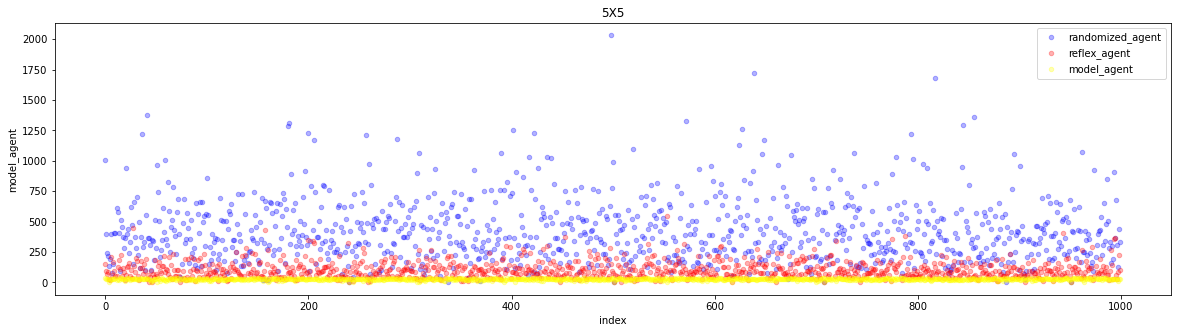

In [16]:
df5X5 = simulation(5,5,1000, max_steps= 1000000, verbose = False, inner_verbose = False)
plotDataFrameAll(df, '5X5')

Here we can see the clear advatange the model based agent gets.  The pure random anget really performs slowly. Below we will look at just the model vs reflex 5X5

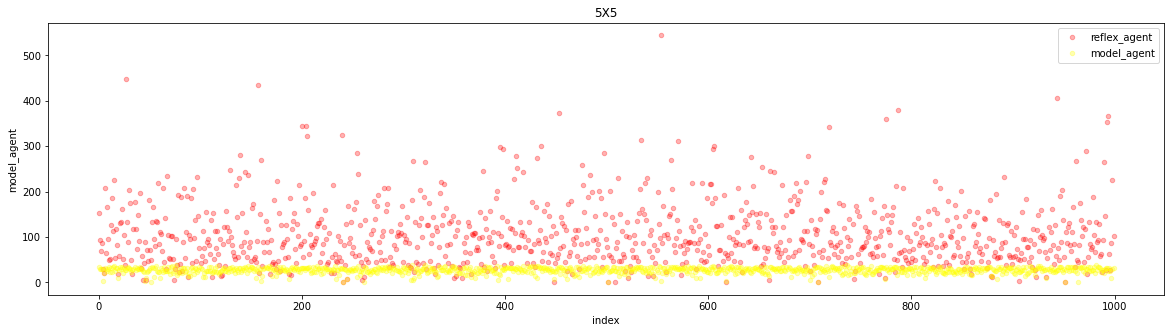

In [17]:
plotDataFrameRelfexModel(df, '5X5')

Above gives a zoomed in picture of this comparison.  We see the model agent outperforming the reflex agent more often that not.  As the grid expands we will continue to look at this relationship.  It will become less and less likely for the random reflex agent to beat the model based agent.

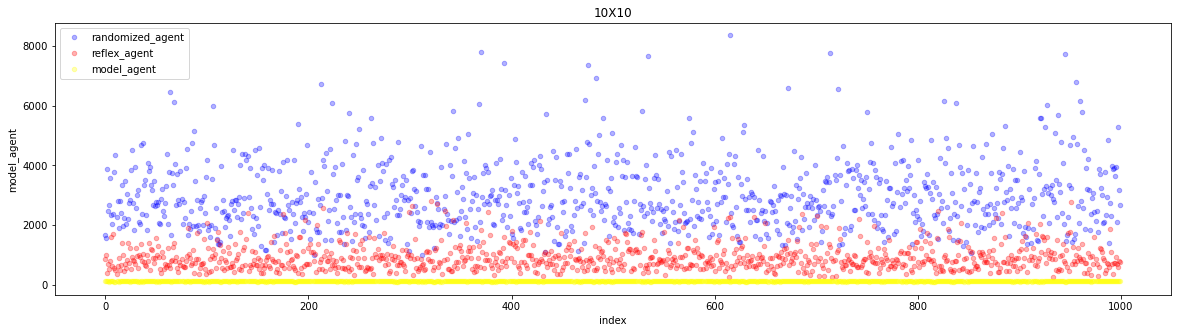

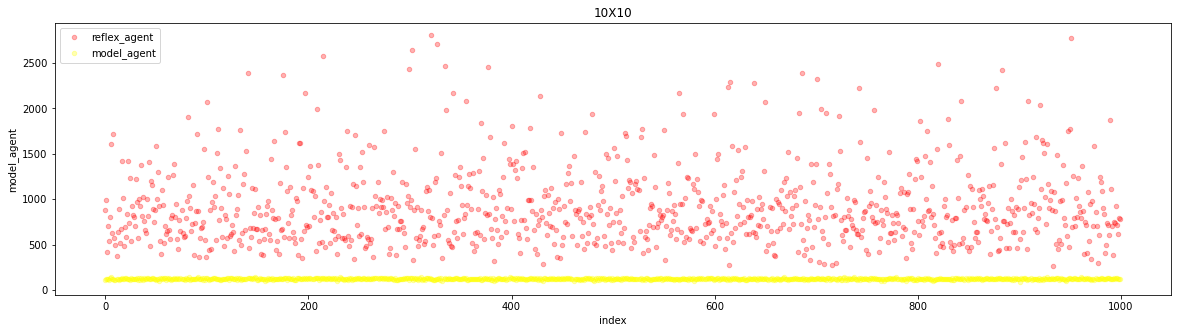

In [19]:
df10X10 = simulation(10,10,1000, max_steps= 1000000, verbose = False, inner_verbose = False)
plotDataFrameAll(df, '10X10')
plotDataFrameRelfexModel(df, '10X10')

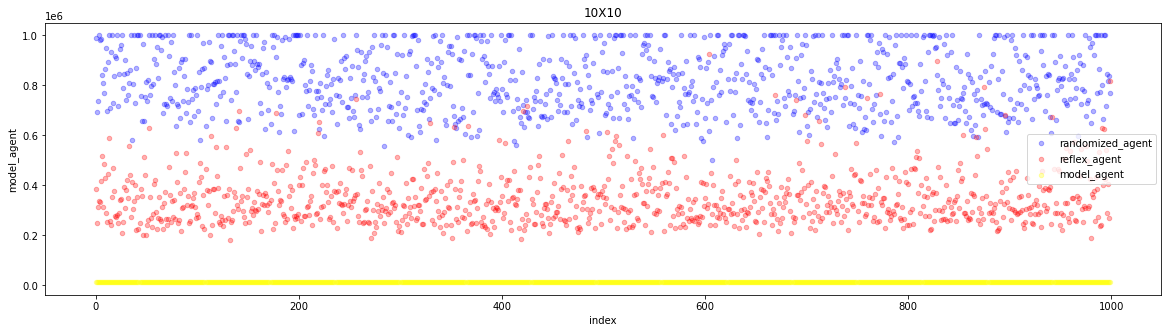

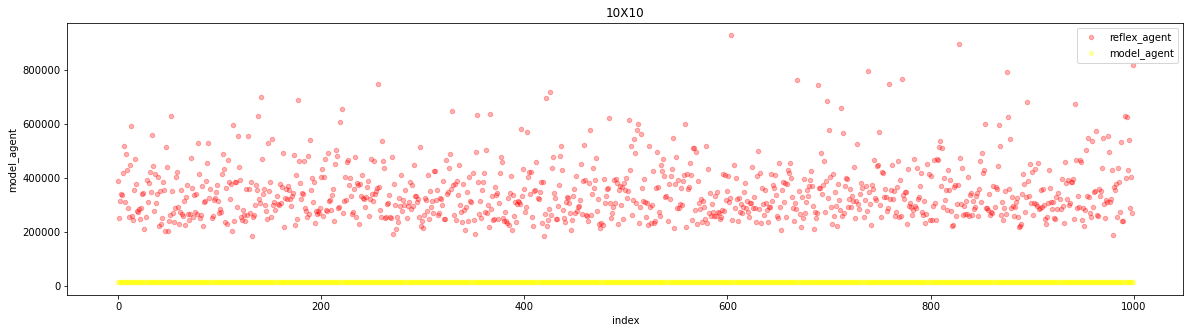

In [30]:
df100X100 = simulation(100,100,1000, max_steps= 1000000, verbose = False, inner_verbose = False)
plotDataFrameAll(df, '10X10')
plotDataFrameRelfexModel(df, '10X10'

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | | | |
| 10x10   | | | |
| 100x100 | | | |

## Task 5: Robustness of the agent implementations [1 Point] 

Describe how your agent implementations will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In [11]:
# Answer goes here

## Graduate student advanced task: Obstacles [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [12]:
# Your code and discussion goes here

## More advanced tasks to think about

You can think about these:

* __Unknown environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square.

* __Utility-based agent:__ Change the environment, so each square has a fixed probability of getting dirty again. We assume the agent has learned this information over time. For the implementation, we give this information to the agent as a 2-dimensional array of probabilities  Cleaning one dirty square produces a utility of 1. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 10000 time steps. This is very tricky!